Preprocessing 

In [1]:
# Import the required libraries and dependencies
import pandas as pd
import tensorflow as tf
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

import findspark
findspark.init()

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
#  Import and read the Ghibli_characters.csv
df = pd.read_csv("Resources\StudioGhibliCharacters.csv")
df.head()

,character name,age,height(cm),eyeColor,hairColor,specialPowers,country/placeOfResidence,gender,species,movie,releaseDate
0,Pazu,13.0,120.0,black,brown,0,Laputa,Male,Human,Castle in the Sky,1986
1,Lusheeta Toel Ul Laputa,13.0,120.0,black,black,1,Laputa,Female,Human,Castle in the Sky,1986
2,Dola,60.0,NaN,black,peach,0,Laputa,Female,Human,Castle in the Sky,1986
3,Romka Palo Ul Laputa,33.0,NaN,black,brown,0,Laputa,Male,Human,Castle in the Sky,1986
4,Uncle Pom,NaN,NaN,black,white,0,Laputa,Male,Human,Castle in the Sky,1986


In [3]:
# Create Path for sqlite databse
Path('ghib_data.db').touch()

# Connect to SQLite database 
conn = sqlite3.connect('ghib_data.db') 
  
# Load CSV data into Pandas DataFrame 
ghib = pd.read_csv('Resources\StudioGhibliCharacters.csv') 
# Write the data to a sqlite table 
ghib.to_sql('sg_char', conn, if_exists='replace', index=False) 
  
# Create a cursor object 
cur = conn.cursor() 
# Fetch and display result 
for row in cur.execute('SELECT * FROM sg_char'): 
    print(row) 

('Pazu', 13.0, 120.0, 'black', 'brown', 0, 'Laputa', 'Male', 'Human', 'Castle in the Sky', 1986)
('Lusheeta Toel Ul Laputa', 13.0, 120.0, 'black', 'black', 1, 'Laputa', 'Female', 'Human', 'Castle in the Sky', 1986)
('Dola', 60.0, None, 'black', 'peach', 0, 'Laputa', 'Female', 'Human', 'Castle in the Sky', 1986)
('Romka Palo Ul Laputa', 33.0, None, 'black', 'brown', 0, 'Laputa', 'Male', 'Human', 'Castle in the Sky', 1986)
('Uncle Pom', None, None, 'black', 'white', 0, 'Laputa', 'Male', 'Human', 'Castle in the Sky', 1986)
('General Muoro', None, None, 'black', 'bald', 0, 'Laputa', 'Male', 'Human', 'Castle in the Sky', 1986)
('Duffi', None, None, 'dark brown', 'dark brown', 0, 'Laputa', 'Male', 'Human', 'Castle in the Sky', 1986)
('Louis', 30.0, None, 'dark brown', 'dark brown', 0, 'Laputa', 'Male', 'Human', 'Castle in the Sky', 1986)
('Charles ', None, None, 'dark brown', 'light brown', 0, 'Laputa', 'Male', 'Human', 'Castle in the Sky', 1986)
('Henri', None, None, 'dark brown', 'reddish 

In [4]:
# Query database for all distinct species and their counts to evaluate how to catergorize predictions
species_query = """
SELECT DISTINCT species, COUNT(species)
FROM sg_char
GROUP BY species;
"""

all_species = pd.read_sql_query(species_query, conn)
all_species

,species,COUNT(species)
0,Arch-Mage,1
1,Bakeneko,1
2,Boar God,1
3,Borrower,5
4,Cat,7
5,Deity,1
6,Dog,1
7,Dragon/Human,1
8,Fire Demon,1
9,Fish/Human,1


In [5]:
# Query database for Males vs Females
male_query = """
SELECT gender, COUNT(gender)
FROM sg_char
GROUP BY gender;
"""

male_characters = pd.read_sql_query(male_query,conn)
male_characters

,gender,COUNT(gender)
0,None,0
1,Female,84
2,Male,98


In [6]:
# Query database for all characters that share same eye color
eyeColor_query = """
SELECT eyeColor, COUNT(eyeColor)
FROM sg_char
GROUP BY eyeColor;
"""

same_eyeColors = pd.read_sql_query(eyeColor_query,conn)
same_eyeColors

,eyeColor,COUNT(eyeColor)
0,None,0
1,black,78
2,black,2
3,blue,5
4,brown,36
5,brown,1
6,dark brown,32
7,emerald,1
8,green,4
9,green grey,1


In [7]:
# Query database for all characters that share hair color
hairColor_query = """
SELECT hairColor, COUNT(hairColor)
FROM sg_char
GROUP BY hairColor;
"""

same_hairColors = pd.read_sql_query(hairColor_query,conn)
same_hairColors

,hairColor,COUNT(hairColor)
0,None,0
1,auburn,3
2,bald,6
3,beige,2
4,beige white,1
5,black,21
6,blonde,6
7,blue,1
8,brown,65
9,brown striped,1


In [8]:
# Query how many characters are in a movie
charInMovie = """
SELECT movie, COUNT('character name') as numberOfCharacters
FROM sg_char
GROUP BY movie;
"""

movies = pd.read_sql_query(charInMovie,conn)
movies

,movie,numberOfCharacters
0,Castle in the Sky,13
1,From Up on Poppy Hill,8
2,Grave of the Fireflies,6
3,Howl's Moving Castle,9
4,Kiki's Delivery Service,6
5,My Neighbor Totoro,10
6,My Neighbors the Yamadas,5
7,Nausicaa of the Valley of the Wind,13
8,Only Yesterday,10
9,Pom Poko,6


In [9]:
# Close connection to SQLite database 
conn.close() 

In [10]:
# Clean dataframe and drop non-beneficial columns
cleanedCharacters = df.drop(columns = ['character name','movie', 'releaseDate', 'country/placeOfResidence', 'gender'], axis=1)
cleanedCharacters.head(20)

,age,height(cm),eyeColor,hairColor,specialPowers,species
0,13.0,120.0,black,brown,0,Human
1,13.0,120.0,black,black,1,Human
2,60.0,NaN,black,peach,0,Human
3,33.0,NaN,black,brown,0,Human
4,NaN,NaN,black,white,0,Human
5,NaN,NaN,black,bald,0,Human
6,NaN,NaN,dark brown,dark brown,0,Human
7,30.0,NaN,dark brown,dark brown,0,Human
8,NaN,NaN,dark brown,light brown,0,Human
9,NaN,NaN,dark brown,reddish brown,0,Human


In [11]:
# Find human median height(cm)
humansCopy = cleanedCharacters.copy()
Humans_df = humansCopy.loc[humansCopy['species'].isin(['Human','New Human'])]
humanMedHeights = Humans_df['height(cm)'].mean()
humanMedHeights

133.0

In [12]:
# Find other species median height(cm)
othersCopy = cleanedCharacters.copy()
OtherSpecies_df = othersCopy.drop(othersCopy[othersCopy['species'] == 'Human'].index)
OtherSpecies_df = OtherSpecies_df.drop(OtherSpecies_df[OtherSpecies_df['species'] == 'New Human'].index)
otherMedHeights = OtherSpecies_df['height(cm)'].mean()
otherMedHeights

113.8

In [13]:
# Find human median age
humanMedAge = Humans_df['age'].median()
humanMedAge

17.0

In [14]:
# Find other species median age
othersMedAge = OtherSpecies_df['age'].median()
othersMedAge

40.0

In [15]:
# Replace all human height NaN values with human median height to keep character
human_character_height = Humans_df['height(cm)'].replace(np.nan, 140)
human_character_height.head()

0    120.0
1    120.0
2    140.0
3    140.0
4    140.0
Name: height(cm), dtype: float64

In [16]:
# Replace all Other Species height NaN values with Other Species median height to keep character
other_character_height = OtherSpecies_df['height(cm)'].replace(np.nan, 113.8)
other_character_height.head()

19    215.0
20    113.8
21    113.8
22    113.8
23    130.0
Name: height(cm), dtype: float64

In [17]:
# Replace all human age NaN values with human median age to keep character
human_character_age = Humans_df['age'].replace(np.nan, 17)
human_character_age.head()

0    13.0
1    13.0
2    60.0
3    33.0
4    17.0
Name: age, dtype: float64

In [18]:
# Replace all other species age NaN values with other species median age to keep character
other_character_age = OtherSpecies_df['age'].replace(np.nan, 40)
other_character_age.head()

19    1302.0
20     679.0
21     109.0
22      40.0
23      13.0
Name: age, dtype: float64

In [19]:
# Replace original human age and height columns with new columns
human_characters_df = Humans_df.copy()
human_characters_df.drop(columns=['age','height(cm)'], axis=1, inplace=True)
human_characters_df['age'] = human_character_age
human_characters_df['height(cm)'] = human_character_height
human_characters_df.tail(10)

,eyeColor,hairColor,specialPowers,species,age,height(cm)
173,brown,grey,0,New Human,17.0,140.0
175,brown,grey,0,New Human,17.0,140.0
176,brown,grey,0,New Human,50.0,140.0
177,NaN,brown,0,New Human,17.0,140.0
178,brown,brown,0,New Human,17.0,140.0
179,brown,brown,0,New Human,16.0,140.0
180,brown,auburn,0,New Human,16.0,140.0
181,brown,brown,0,New Human,17.0,140.0
182,blue,ginger,0,New Human,25.0,140.0
183,brown,brown,0,New Human,17.0,140.0


In [20]:
# Replace original other species age and height columns with new columns
other_characters_df = OtherSpecies_df.copy()
other_characters_df.drop(columns=['age','height(cm)'], axis=1, inplace=True)
other_characters_df['age'] = other_character_age
other_characters_df['height(cm)'] = other_character_height
other_characters_df.tail(10)

,eyeColor,hairColor,specialPowers,species,age,height(cm)
122,brown,red,1,Deity,600.0,150.0
128,black,auburn,0,Borrower,14.0,10.0
129,brown,navy blue,0,Borrower,13.0,8.0
130,brown,navy black,0,Borrower,52.0,11.0
133,black,navy black,0,Borrower,18.0,9.0
134,grey,brown,0,Borrower,52.0,12.0
135,white,beige,0,Cat,40.0,113.8
152,black,navy blue,1,Moon Princess,40.0,150.0
159,green grey,grey,1,Boar God,500.0,200.0
174,green,brown striped,0,Fox Squirrel,40.0,113.8


In [21]:
# Concat both dataframes to form one again
dfs = [human_characters_df, other_characters_df]
final_characters_df = pd.concat(dfs)
final_characters_df

,eyeColor,hairColor,specialPowers,species,age,height(cm)
0,black,brown,0,Human,13.0,120.0
1,black,black,1,Human,13.0,120.0
2,black,peach,0,Human,60.0,140.0
3,black,brown,0,Human,33.0,140.0
4,black,white,0,Human,17.0,140.0
...,...,...,...,...,...,...
134,grey,brown,0,Borrower,52.0,12.0
135,white,beige,0,Cat,40.0,113.8
152,black,navy blue,1,Moon Princess,40.0,150.0
159,green grey,grey,1,Boar God,500.0,200.0


In [22]:
# Scale age and height values
data_scaled = StandardScaler().fit_transform(
    final_characters_df[["age","height(cm)"]]
)

In [23]:
# Create a DataFrame with the scaled data
df_data_scaled = pd.DataFrame(
    data_scaled,
    columns=[["age","height(cm)"]]
)

# Display sample data
df_data_scaled.head()

,age,height(cm)
0,-0.272398,-0.417402
1,-0.272398,-0.417402
2,0.104936,0.263406
3,-0.111830,0.263406
4,-0.240285,0.263406


In [24]:
# Use get_dummies to convert categorical values to numerical values
cat_dum = final_characters_df.copy()
cat_dum.drop(columns=["age","species","height(cm)"], axis=1, inplace=True)
cat_dum2 = pd.concat([cat_dum, df_data_scaled], axis=1)
ghibli_dummies = pd.get_dummies(cat_dum2)
ghibli_dummies.head()

,specialPowers,"(age,)","(height(cm),)",eyeColor_black,eyeColor_black,eyeColor_blue,eyeColor_brown,eyeColor_brown,eyeColor_dark brown,eyeColor_emerald,...,hairColor_orange yellow,hairColor_peach,hairColor_purple,hairColor_red,hairColor_red,hairColor_reddish brown,hairColor_russian blue,hairColor_white,hairColor_whtie,hairColor_yellow
0,0,-0.272398,-0.417402,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,-0.272398,-0.417402,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0,0.104936,0.263406,True,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3,0,-0.111830,0.263406,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0,-0.240285,0.263406,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [25]:
print(ghibli_dummies)

     specialPowers     (age,)  (height(cm),)  eyeColor_black  eyeColor_black   \
0                0  -0.272398      -0.417402            True            False   
1                1  -0.272398      -0.417402            True            False   
2                0   0.104936       0.263406            True            False   
3                0  -0.111830       0.263406            True            False   
4                0  -0.240285       0.263406            True            False   
..             ...        ...            ...             ...              ...   
134              0  -0.240285       0.263406           False            False   
135              0  10.076198       2.816435           False            False   
152              1  -0.280426       1.625021            True            False   
159              1  -0.055632      -3.140632           False            False   
174              0   4.440267       0.603810           False            False   

     eyeColor_blue  eyeColo

In [26]:
# Create Species Class dataframe for further catergorizing
species_class = final_characters_df['species']
species_class.head()

0    Human
1    Human
2    Human
3    Human
4    Human
Name: species, dtype: object

In [27]:
# Create All Human species classifications to be replaced with 0
Humans = species_class[(species_class == "Human") | (species_class == "New Human")]

# Replace in dataframe
for species in Humans:
    final_characters_df['species'] = final_characters_df['species'].replace(species,"0")

# Check to make sure binning was successful
final_characters_df['species']

0                  0
1                  0
2                  0
3                  0
4                  0
           ...      
134         Borrower
135              Cat
152    Moon Princess
159         Boar God
174     Fox Squirrel
Name: species, Length: 184, dtype: object

In [28]:
# Create All other species classifications to be replaced with 1
OtherSpecies = species_class[species_class != "Human"]

# Replace in dataframe
for species in OtherSpecies:
    final_characters_df['species'] = final_characters_df['species'].replace(species,"1")

# Check to make sure binning was successful
final_characters_df['species'].head(20)

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
26    0
Name: species, dtype: object

In [29]:
# Split data into features and target arrays
y = final_characters_df['species'].astype('float64')
X = ghibli_dummies.values

In [30]:
# Show first 3 X values
X[:3]

array([[0, -0.2723980708741599, -0.41740167852823884, True, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, True, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False],
       [1, -0.2723980708741599, -0.41740167852823884, True, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False],
       [0, 0.1049363063354725, 0.2634059524370664, True, False, False,
        False

In [31]:
# Show first 20 y values
y[:20]

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
26    0.0
Name: species, dtype: float64

In [32]:
# Split data into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)
print("Training Data Info")
print("Training Data Shape:", X_train.shape)
print("Training Data Labels Shape:", y_train.shape)

Training Data Info
Training Data Shape: (138, 54)
Training Data Labels Shape: (138,)


In [33]:
# Create Standard Scaler
scaler = StandardScaler()

# Fit scaler to training data
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [34]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=5, activation='relu', input_dim=54))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=10, activation='relu'))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=20, activation='tanh'))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 275       
                                                                 
 dense_1 (Dense)             (None, 10)                60        
                                                                 
 dense_2 (Dense)             (None, 20)                220       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 576 (2.25 KB)
Trainable params: 576 (2.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

In [36]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
5/5 [==============================] - 1s 2ms/step - loss: 0.6928 - accuracy: 0.5217
Epoch 2/100
5/5 [==============================] - 0s 1ms/step - loss: 0.6730 - accuracy: 0.6304
Epoch 3/100
5/5 [==============================] - 0s 1ms/step - loss: 0.6564 - accuracy: 0.7536
Epoch 4/100
5/5 [==============================] - 0s 2ms/step - loss: 0.6406 - accuracy: 0.7971
Epoch 5/100
5/5 [==============================] - 0s 1ms/step - loss: 0.6273 - accuracy: 0.8043
Epoch 6/100
5/5 [==============================] - 0s 1ms/step - loss: 0.6149 - accuracy: 0.8116
Epoch 7/100
5/5 [==============================] - 0s 1ms/step - loss: 0.6019 - accuracy: 0.8188
Epoch 8/100
5/5 [==============================] - 0s 1ms/step - loss: 0.5896 - accuracy: 0.8043
Epoch 9/100
5/5 [==============================] - 0s 2ms/step - loss: 0.5773 - accuracy: 0.8116
Epoch 10/100
5/5 [==============================] - 0s 1ms/step - loss: 0.5661 - accuracy: 0.8116
Epoch 11/100
5/5 [===========

In [37]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

2/2 - 0s - loss: 0.7298 - accuracy: 0.8043 - 124ms/epoch - 62ms/step
Loss: 0.7298314571380615, Accuracy: 0.804347813129425


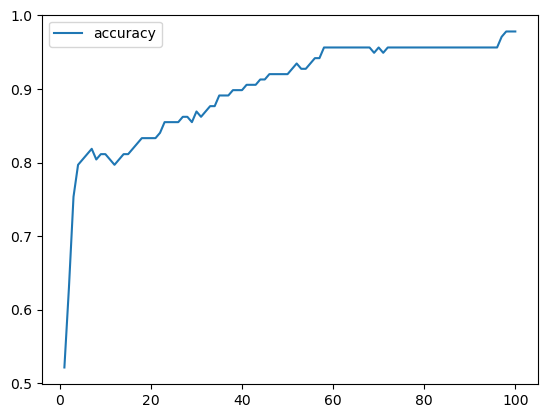

In [38]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the accuracy
history_df.plot(y="accuracy")
plt.show()

In [39]:
# Export our model to HDF5 file
nn.save('SGDemo_Model.h5')

C:\Users\xiong\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
